In [1]:
!gsutil -m cp gs://project_shm/Image_224.npy ./

Copying gs://project_shm/Image_224.npy...
- [1/1 files][  2.4 GiB/  2.4 GiB] 100% Done  80.5 MiB/s ETA 00:00:00           
Operation completed over 1 objects/2.4 GiB.                                      


In [2]:
!gsutil -m cp gs://project_shm/Label_224.npy ./

Copying gs://project_shm/Label_224.npy...
/ [1/1 files][131.3 KiB/131.3 KiB] 100% Done                                    
Operation completed over 1 objects/131.3 KiB.                                    


In [4]:
# !pip install imblearn

     |████████████████████████████████| 174kB 4.8MB/s eta 0:00:01
ERROR: Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/usr/local/lib/python3.5/dist-packages/imblearn'
Consider using the `--user` option or check the permissions.



In [1]:
import tensorflow as tf
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from tensorflow import keras
import matplotlib.pyplot as plot
import numpy as np
# from imblearn.over_sampling import BorderlineSMOTE

In [2]:
np_Images = np.load('Image_224.npy') #converting the list of images to numpy array.
np_Labels = np.load('Label_224.npy')

In [3]:
print("Shape of Images:",np_Images.shape)
print("Shape of Labels:",np_Labels.shape)

Shape of Images: (16785, 224, 224, 3)
Shape of Labels: (16785,)


In [4]:
np.bincount(np_Labels)

array([9955,  229,  766, 2061,  426, 3348])

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
len(np_Images)

16785

In [ ]:
X_train_tmp, X_test, y_train_tmp, y_test = train_test_split(np_Images, np_Labels, test_size=0.1, random_state=1, stratify=np_Labels)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train_tmp, y_train_tmp, test_size=0.11, random_state=1 ,stratify=y_train_tmp)

In [9]:
np.bincount(y_train)

array([7973,  183,  613, 1651,  342, 2682])

In [10]:
X_train.shape, y_train.shape

((13444, 224, 224, 3), (13444,))

In [11]:
IMG_SHAPE = X_train[0].shape

base_model =tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                                          include_top=False,
                                                          weights='imagenet')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
94773248/94765736 [==============================] - 3s 0us/step


In [12]:
base_model.trainable = False

In [14]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [19]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    
    tf.keras.layers.Dense(256, activation=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    
    tf.keras.layers.Dense(64, activation=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    tf.keras.layers.Dense(6, activation='softmax') 
])

In [20]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
re_lu (ReLU)                 (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                2

In [22]:
base_model.trainable = False

In [23]:
model.trainable_variables

[<tf.Variable 'dense_1/kernel:0' shape=(2048, 256) dtype=float32>,
 <tf.Variable 'dense_1/bias:0' shape=(256,) dtype=float32>,
 <tf.Variable 'batch_normalization/gamma:0' shape=(256,) dtype=float32>,
 <tf.Variable 'batch_normalization/beta:0' shape=(256,) dtype=float32>,
 <tf.Variable 'dense_2/kernel:0' shape=(256, 64) dtype=float32>,
 <tf.Variable 'dense_2/bias:0' shape=(64,) dtype=float32>,
 <tf.Variable 'batch_normalization_1/gamma:0' shape=(64,) dtype=float32>,
 <tf.Variable 'batch_normalization_1/beta:0' shape=(64,) dtype=float32>,
 <tf.Variable 'dense_3/kernel:0' shape=(64, 6) dtype=float32>,
 <tf.Variable 'dense_3/bias:0' shape=(6,) dtype=float32>]

In [24]:
callback = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=False)]

In [25]:
#trained = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val,y_val))
trained = model.fit(X_train, y_train, epochs=30, batch_size=256, validation_data=(X_val,y_val), callbacks=callback)

Train on 13444 samples, validate on 1662 samples
Epoch 1/30
13444/13444 [==============================] - 46s 3ms/sample - loss: 0.3942 - acc: 0.8952 - val_loss: 0.7843 - val_acc: 0.7581
Epoch 2/30
13444/13444 [==============================] - 38s 3ms/sample - loss: 0.1080 - acc: 0.9746 - val_loss: 0.9487 - val_acc: 0.7100
Epoch 3/30
13444/13444 [==============================] - 38s 3ms/sample - loss: 0.0498 - acc: 0.9929 - val_loss: 0.8814 - val_acc: 0.7226
Epoch 4/30
13444/13444 [==============================] - 38s 3ms/sample - loss: 0.0248 - acc: 0.9979 - val_loss: 1.1786 - val_acc: 0.6853
Epoch 5/30
13444/13444 [==============================] - 38s 3ms/sample - loss: 0.0132 - acc: 0.9999 - val_loss: 1.1090 - val_acc: 0.6955
Epoch 6/30
13444/13444 [==============================] - 38s 3ms/sample - loss: 0.0079 - acc: 1.0000 - val_loss: 1.0516 - val_acc: 0.7118
Epoch 7/30
13444/13444 [==============================] - 38s 3ms/sample - loss: 0.0056 - acc: 0.9999 - val_loss: 1.1

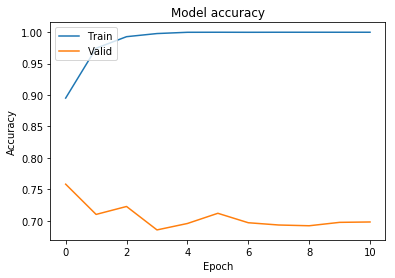

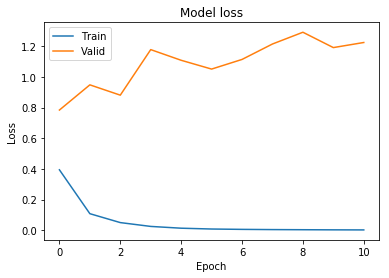

In [26]:
plot.plot(trained.history['acc'])
plot.plot(trained.history['val_acc'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Valid'], loc='upper left')
plot.show()

plot.plot(trained.history['loss'])
plot.plot(trained.history['val_loss'])
plot.title('Model loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', 'Valid'], loc='upper left')
plot.show()

In [27]:
model.evaluate(X_test,y_test, verbose=1)

1679/1679 [==============================] - 4s 2ms/sample - loss: 1.1739 - acc: 0.7225


[1.1739303691178435, 0.72245383]

In [38]:
model.predict(X_test)

array([[0.9585722 , 0.00956048, 0.00290462, 0.0083871 , 0.01352266,
        0.00705296],
       [0.13872768, 0.8231202 , 0.00865367, 0.00546651, 0.00870402,
        0.01532788],
       [0.17477226, 0.7334145 , 0.00435064, 0.00519526, 0.07700448,
        0.00526284],
       ...,
       [0.8416028 , 0.1070707 , 0.00852146, 0.00295843, 0.00402796,
        0.03581864],
       [0.90587693, 0.06894061, 0.00304482, 0.00351622, 0.01466624,
        0.00395517],
       [0.90264404, 0.0306741 , 0.00780508, 0.00172588, 0.00208898,
        0.05506182]], dtype=float32)